In [1]:
!cd ./nqs; python -m pip install -e .

Obtaining file:///home/aleksei/Research/NQS-master/nqs
  Preparing metadata (setup.py) ... done
  Attempting uninstall: nqs
    Found existing installation: nqs 0.1
    Uninstalling nqs-0.1:
      Successfully uninstalled nqs-0.1
  Running setup.py develop for nqs


In [36]:
import os
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

In [3]:
from nqs.nqs.applications.quantum_chemistry.molecule import GeometryConfig, MolConfig
from nqs.nqs.applications.quantum_chemistry.experiments.preparation import create_mol

from nqs.nqs.applications.quantum_chemistry.experiments.energy_opt_exp import EnergyOptExpConfig, EnergyOptExp

from nqs.nqs.applications.quantum_chemistry import CHEMICAL_ACCURACY

In [4]:
mols_root_dir = './molecules'

mol_name = 'Li2O'

In [5]:
geom = [["O", [0.0, 0.0, 0.0]],
        ["Li", [0.0, 0.0, 1.51903]],
        ["Li", [0.0, 0.0, -1.51903]]]

geom_config = GeometryConfig(type='toy', idx=0)
geom_dir = os.path.join(mols_root_dir,
                       f'name={mol_name}',
                       'geometries',
                        geom_config.to_path_suffix())

if not os.path.exists(geom_dir):
    os.makedirs(geom_dir)

geom_filename = os.path.join(geom_dir, 'geom.json')

if not os.path.exists(geom_filename):
    with open(geom_filename, 'w') as f:
        json.dump(geom, f)
else:
    print(f'You are trying to overwrite an existing geometry at {geom_filename}')

You are trying to overwrite an existing geometry at ./molecules/name=Li2O/geometries/type=toy/idx=0/geom.json


In [6]:
mol_config = MolConfig(name=mol_name,
                       geom_config=geom_config,
                       basis='sto-3g')
mol = create_mol(config=mol_config,
                 mols_root_dir=mols_root_dir)

The molecule filename exists
The init config does not prescribe to reinit the Molecule


In [56]:
series_name = 'toy'
exp_config = EnergyOptExpConfig(mols_root_dir=mols_root_dir,
                                mol_config=mol_config,
                                series_name=series_name)
exp_config.local_energy_config.use_tree_for_candidates = 'trie'
exp_config.proc_grad_schedule[0][1].use_sr = True
exp_config.proc_grad_schedule[0][1].sr_config.max_indices_num = 50

In [57]:
energy_opt_exp = EnergyOptExp(config=exp_config,
                              mol=mol)

/home/aleksei/miniconda3/envs/nqs_master/lib/python3.12/site-packages/pennylane/ops/op_math/prod.py:499: PennyLaneDeprecationWarning: Prod.ops is deprecated and will be removed in future releases. You can access both (coeffs, ops) via op.terms() Also consider op.operands.
  warnings.warn(


In [58]:
for method in ('hf', 'cisd', 'ccsd', 'ccsd_t', 'fci'):
    print(f'{method} energy: {getattr(energy_opt_exp.mol, f"{method}_energy")}')
if energy_opt_exp.mol.fci_energy is not None:
    print(f'fci energy up to chem. acc.: {energy_opt_exp.mol.fci_energy + CHEMICAL_ACCURACY}')
energy_opt_exp.run(iter_num=500)

hf energy: -88.58153042201909
cisd energy: -88.69115384730222
ccsd energy: -88.69444462196275
ccsd_t energy: -88.70540598879934
fci energy: -88.70545072446566
fci energy up to chem. acc.: -88.70385072446567


  0%|          | 0/500 [00:00<?, ?it/s]

# Building plots

In [59]:
series_dir = os.path.join(mol.dir, 'exp_series', series_name)
result_filename = os.path.join(series_dir, f'{exp_config.to_sha256_str()}', 'result.csv')
result = pd.read_csv(result_filename)

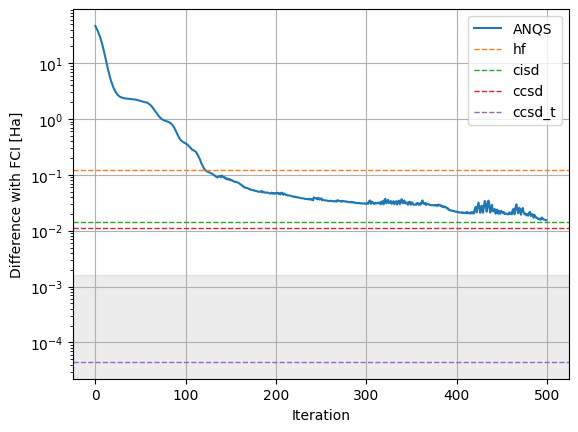

In [60]:
fig, ax = plt.subplots()
ax.grid()
ax.plot(result['iter_idx'],
        result['sample_aware_energy'] - mol.fci_energy,
        label='ANQS')
ax.set_yscale('log')

x_lim = ax.get_xlim()

point_num = 10
x_axis = np.linspace(x_lim[0], x_lim[1], point_num)
for method in ('hf', 'cisd', 'ccsd', 'ccsd_t'):
    ax.plot(x_axis,
            np.ones_like(x_axis) * getattr(mol, f'{method}_energy') - mol.fci_energy,
            label=method,
            linestyle='dashed',
            linewidth=1)
ax.fill_between([x_lim[0], x_lim[1]], 0, 1.6e-3, color='grey', alpha=0.15)
ax.set_xlim(x_lim)

ax.set_xlabel('Iteration')
ax.set_ylabel('Difference with FCI [Ha]')
ax.legend(loc='best')